In [0]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [0]:
# Upload data
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
!tar xvzf track_shower_images.tar.gz

Images/
Images/Hits/
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_0_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_100_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_101_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_102_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_103_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_104_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_105_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_106_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_107_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_108_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_109_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_10_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_110_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_111_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_112_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_113_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_114_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_115_0.png
Images/Hits/Image_DUNEFD_MC1

In [0]:
# Reduce to just 100 images
#!rm -f Images/Truth/Image*_[0-9][0-9][0-9]_0.png
#!rm -f Images/Hits/Image*_[0-9][0-9][0-9]_0.png
#!rm -f *.py

In [0]:
# Upload supporting python modules
!rm -f *.py
from google.colab import files
files.upload()

Saving data.py to data.py
Saving img_util.py to img_util.py
Saving model_util.py to model_util.py
Saving transforms.py to transforms.py
Saving unet.py to unet.py


{'data.py': b'import numpy as np\nimport torch\nimport os\nimport PIL\nfrom torch.utils.data import Dataset\nfrom torch.utils.data import DataLoader\n\ndef open_image(path):\n    img = PIL.Image.open(path)\n    if img.mode  != \'L\':\n        img = img.convert(\'L\')\n    return img\n\nclass SegmentationDataset(Dataset):\n    """Dataset suitable for segmentation tasks."""\n\n    def __init__(self, image_dir, mask_dir, filenames, transform=None):\n        """\n        Args:\n            root_dir (string): Directory with all images and masks.\n            image_dir (string): The relative directory containing the images.\n            mask_dir (string): The relative directory containing the masks.\n            transform (callable, optional): Optional transform to be applied\n                on a sample.\n        """\n        self.image_dir = image_dir\n        self.mask_dir = mask_dir\n        self.transform = transform\n        self.filenames = filenames\n        self.mean = 0.\n        s

In [0]:
from data import SegmentationBunch
from transforms import Rescale, ToTensor
from unet import UNet
import img_util as iu
import model_util as mu

In [0]:
from data import open_image
img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0.png")

In [0]:
img.size

(512, 208)

In [0]:
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.optim as opt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=48, valid_pct = 0.2,
    transform=transforms.Compose([ToTensor(True)]))
#bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=16, valid_pct = 0.2,
#    transform=transforms.Compose([ToTensor(True)]))

In [0]:
count = {0: 0, 1: 0, 2: 0}
for batch in bunch.train_dl:
    images, masks = batch
    unique, counts = torch.unique(masks, return_counts=True)
    unique = [ u.item() for u in unique ]
    counts = [ c.item() for c in counts ]
    this_dict = dict(zip(unique, counts))
    for key in this_dict:
            count[key] += this_dict[key]

In [116]:
count
# There are 95973 shower hits and 127659 track hits in the training data set (last batch dropped)

{0: 81565296, 1: 95973, 2: 127659}

In [0]:
count = {0: 0, 1: 0, 2: 0}
for batch in bunch.valid_dl:
    images, masks = batch
    unique, counts = torch.unique(masks, return_counts=True)
    unique = [ u.item() for u in unique ]
    counts = [ c.item() for c in counts ]
    this_dict = dict(zip(unique, counts))
    for key in this_dict:
            count[key] += this_dict[key]

In [118]:
count
# Theere are 22073 shower hits and 32280 track hits in the validation set (relatively more tracks)

{0: 20392879, 1: 22073, 2: 32280}

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

batch = None
for b in bunch.train_dl:
    batch, _ = b
    break

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
c_in = 1
c_out = 16
conv = nn.Conv2d(c_in, c_out, kernel_size = 3, padding = 1, stride = 1)
print("Input stats", get_stats(batch))
output = conv(batch)
print("Output stats", get_stats(output))

Input stats (tensor(0.0021), tensor(1.0202))
Output stats (tensor(0.1029, grad_fn=<MeanBackward0>), tensor(0.4455, grad_fn=<StdBackward0>))


In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
c_in = 1
c_out = 16
conv = nn.Conv2d(c_in, c_out, kernel_size = 3, padding = 1, stride = 1)
# Kaiming uniform reweighting - no ReLU
nn.init.kaiming_uniform_(conv.weight, a=1.0)
conv.bias.data.zero_()
output = conv(batch)
print("Output stats", get_stats(output))

Output stats (tensor(-0.0009, grad_fn=<MeanBackward0>), tensor(0.9992, grad_fn=<StdBackward0>))


In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
c_in = 1
c_out = 16
leak = 0.0
conv1 = nn.Conv2d(c_in, c_out, kernel_size = 3, padding = 1, stride = 1)
bn1 = nn.BatchNorm2d(c_out)
relu1 = nn.LeakyReLU(leak)
seq1 = nn.Sequential(conv1, bn1, relu1)
conv2 = nn.Conv2d(c_out, c_out, kernel_size = 3, padding = 1, stride = 1)
bn2 = nn.BatchNorm2d(c_out)
relu2 = nn.LeakyReLU(leak)
seq2 = nn.Sequential(conv2, bn2, relu2)
pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
drop2 = nn.Dropout(0.1)

# Transpose
#conv3 = nn.ConvTranspose2d(c_out, c_out // 2, kernel_size = 3, padding = 1, output_padding = 1, stride = 2)
#bn3 = nn.BatchNorm2d(c_out // 2)
#relu3 = nn.ReLU()
#seq3 = nn.Sequential(conv3, bn3, relu3)

convs = [conv1, conv2, conv3]

# Kaiming uniform reweighting - standard ReLU
std_sum = 0.
mu_sum = 0.
N = 10
for i in list(range(N)):
    for conv in convs:
        nn.init.kaiming_normal_(conv.weight, a=leak)
        #conv.bias.data.zero_()
    output = drop2(pool2(seq2(seq1(batch))))
    mu, std = get_stats(output)
    print(mu, std)
    mu_sum += mu.item()
    std_sum += std.item()
print("Average mu, std", mu_sum / N, std_sum / N)

tensor(0.1378, grad_fn=<MeanBackward0>) tensor(1.1432, grad_fn=<StdBackward0>)
tensor(0.1366, grad_fn=<MeanBackward0>) tensor(1.1842, grad_fn=<StdBackward0>)
tensor(0.1311, grad_fn=<MeanBackward0>) tensor(1.0548, grad_fn=<StdBackward0>)
tensor(0.1390, grad_fn=<MeanBackward0>) tensor(1.1823, grad_fn=<StdBackward0>)
tensor(0.1337, grad_fn=<MeanBackward0>) tensor(1.0878, grad_fn=<StdBackward0>)
tensor(0.1483, grad_fn=<MeanBackward0>) tensor(1.3218, grad_fn=<StdBackward0>)
tensor(0.1436, grad_fn=<MeanBackward0>) tensor(1.2559, grad_fn=<StdBackward0>)
tensor(0.1302, grad_fn=<MeanBackward0>) tensor(1.0275, grad_fn=<StdBackward0>)
tensor(0.1416, grad_fn=<MeanBackward0>) tensor(1.2239, grad_fn=<StdBackward0>)
tensor(0.1487, grad_fn=<MeanBackward0>) tensor(1.2949, grad_fn=<StdBackward0>)
Average mu, std 0.1390610307455063 1.1776354670524598


In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
in_dim = 1
n_filters = 16
n_classes = 3
y_range = (0, 3)

c1 = conv2d_block(in_dim, n_filters * 1)
m1 = maxpool()
d1 = dropout(0.1)

c2 = conv2d_block(n_filters * 1, n_filters * 2)
m2 = maxpool()
d2 = dropout(0.1)

c3 = conv2d_block(n_filters * 2, n_filters * 4)
m3 = maxpool()
d3 = dropout(0.1)

c4 = conv2d_block(n_filters * 4, n_filters * 8)
m4 = maxpool()
d4 = dropout(0.1)

c5 = conv2d_block(n_filters * 8, n_filters * 16)

t6 = conv2d_block_transpose(n_filters * 16, n_filters * 8)
d6 = dropout(0.1)
c6 = conv2d_block(n_filters * 16, n_filters * 8)

t7 = conv2d_block_transpose(n_filters * 8, n_filters * 4)
d7 = dropout(0.1)
c7 = conv2d_block(n_filters * 8, n_filters * 4)

t8 = conv2d_block_transpose(n_filters * 4, n_filters * 2)
d8 = dropout(0.1)
c8 = conv2d_block(n_filters * 4, n_filters * 2)

t9 = conv2d_block_transpose(n_filters * 2, n_filters * 1)
d9 = dropout(0.1)
c9 = conv2d_block(n_filters * 2, n_filters * 1)

fout = nn.Sequential(
        nn.Conv2d(n_filters * 1, n_classes, 1),
        SigmoidRange(*y_range)
    )

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
std_sum = 0.
mu_sum = 0.
N = 10
for i in list(range(N)):
    c1_out = c1(batch)
    output = d1(m1(c1_out))
    c2_out = c2(output)
    output = d2(m2(c2_out))
    c3_out = c3(output)
    output = d3(m3(c3_out))
    c4_out = c4(output)
    output = d4(m4(c4_out))
    output = c5(output)

    output = c6(d6(torch.cat([t6(output), c4_out], dim=1)))
    output = c7(d7(torch.cat([t7(output), c3_out], dim=1)))
    output = c8(d8(torch.cat([t8(output), c2_out], dim=1)))
    output = c9(d9(torch.cat([t9(output), c1_out], dim=1)))
    output = fout(output)

    mu, std = get_stats(output)
    print(mu, std)
    mu_sum += mu.item()
    std_sum += std.item()
print("Average mu, std", mu_sum / N, std_sum / N)

tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2029, grad_fn=<StdBackward0>)
tensor(1.4174, grad_fn=<MeanBackward0>) tensor(0.2032, grad_fn=<StdBackward0>)
tensor(1.4177, grad_fn=<MeanBackward0>) tensor(0.2031, grad_fn=<StdBackward0>)
tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2031, grad_fn=<StdBackward0>)
tensor(1.4177, grad_fn=<MeanBackward0>) tensor(0.2028, grad_fn=<StdBackward0>)
tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2028, grad_fn=<StdBackward0>)
tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2026, grad_fn=<StdBackward0>)
tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2029, grad_fn=<StdBackward0>)
tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2030, grad_fn=<StdBackward0>)
tensor(1.4176, grad_fn=<MeanBackward0>) tensor(0.2030, grad_fn=<StdBackward0>)
Average mu, std 1.4175953030586244 0.20292393565177919


In [0]:
void_code = 0

def accuracy(input, truth):
    target = truth.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

SHOWER = 1
TRACK = 2
def type_accuracy(input, truth, type):
    target = truth.squeeze(1)
    mask = target == type
    #print("Target shape:", target.shape)
    #print("Mask shape:", mask.shape)
    typestr = "SHOWER" if type == SHOWER else "TRACK"
    #print(f"Num mask {typestr} = {torch.sum(mask)}")
    #print(f"Num input {typestr} = {torch.sum(input.argmax(dim=1)[target != void_code] == type)}")
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [120]:
# Create the network, loss function and optimizer
num_epochs = 5
n_classes = 3
model = UNet(1, n_classes = n_classes, n_filters = 16, y_range = (0, n_classes))
#print(model)
num_shower_hits = 95973
num_track_hits = 127659
num_void_hits = 81565296
# Invert weighting to balance affect on loss function
weights = [1. / num_void_hits, 1. / num_shower_hits, 1. / num_track_hits]
weights = [weight / sum(weights) for weight in weights]
print("Weights:", weights)
loss_fn = nn.CrossEntropyLoss(torch.tensor(weights))
#optim = opt.Adam(model.parameters())
#optim = opt.Adam(model.parameters(), lr=2e-4)
#optim = opt.Adam(model.parameters(), lr=1e-4)
# Smoothest training, consistent with lr_finder
#optim = opt.Adam(model.parameters(), lr=1.5e-4)
#optim = opt.Adam(model.parameters(), lr=1.5e-4, weight_decay=0.1)
# New but untested, may also want to add weight decay to lr_finder,
# Might be worth testing a max of 2e-3 as well
#max_lr = 1e-3
max_lr = 5e-3
optim = opt.Adam(model.parameters(), lr=max_lr, weight_decay=0.1)
from torch.optim.lr_scheduler import OneCycleLR
# Want a cleaner way to get the number of batches
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=10.0)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=10.0)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=2.0)
#scheduler = OneCycleLR(optim, max_lr*10, total_steps=len(bunch.train_dl) * num_epochs, pct_start=0.2, div_factor=10.0)
scheduler = OneCycleLR(optim, max_lr * 2, anneal_strategy='linear', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.05, div_factor=2.0)
#scheduler = OneCycleLR(optim, max_lr * 2, anneal_strategy='cos', total_steps = num_epochs * len(bunch.train_dl), pct_start=0.05, div_factor=2.0)
# maybbe change final_div_factor too, because div by 10K is probably massive overkill for short runs
# Temp scheduler to not change rate
#from torch.optim.lr_scheduler import LambdaLR
#scheduler = LambdaLR(optim, lambda epoch: 10.)

Weights: [0.0006712271831704981, 0.5704608991961062, 0.42886787362072315]


In [0]:
# Find learning rate
#optim = opt.Adam(model.parameters(), lr=1e-7)
#num_iter = 100
#lr_lambda = lambda batch : get_running_factor(1e-7, 10, num_iter, batch)
min_lr = 2e-4
max_lr = 2
optim = opt.Adam(model.parameters(), lr=min_lr, weight_decay=0.1)
num_iter = 50
lr_finder = mu.LRFinder(optim=optim, num_iter=num_iter, low_lr=min_lr, high_lr=max_lr)
lr_finder.find(model=model, input=bunch.train_dl, loss_fn=loss_fn)

Batch 0 has learning rate [0.0002]
Batch 1 has learning rate [0.00024135852812786572]
Batch 2 has learning rate [0.00029126969550024873]
Batch 3 has learning rate [0.00035150212497095834]
Batch 4 has learning rate [0.0004241901775840381]
Batch 5 has learning rate [0.000511909584539907]
Batch 6 has learning rate [0.000617768719295496]
Batch 7 has learning rate [0.0007455187440629878]
Batch 8 has learning rate [0.0008996865337938888]
Batch 9 has learning rate [0.0010857350878647714]
Batch 10 has learning rate [0.001310257113719101]
Batch 11 has learning rate [0.001581208642181539]
Batch 12 has learning rate [0.0019081909526999865]
Batch 13 has learning rate [0.002302790798652893]
Batch 14 has learning rate [0.0027789909887462726]
Batch 15 has learning rate [0.0033536658736220133]
Batch 0 has learning rate [0.004047179295450311]
Batch 1 has learning rate [0.004884106189097298]
Batch 2 has learning rate [0.005894103405103615]
Batch 3 has learning rate [0.00711296061244625]
Batch 4 has lear

In [0]:
learning_rates = lr_finder.get_learning_rates()
train_loss_epochs = lr_finder.get_losses()

In [0]:
print(learning_rates)

[2.00000000e-04 2.41358528e-04 2.91269696e-04 3.51502125e-04
 4.24190178e-04 5.11909585e-04 6.17768719e-04 7.45518744e-04
 8.99686534e-04 1.08573509e-03 1.31025711e-03 1.58120864e-03
 1.90819095e-03 2.30279080e-03 2.77899099e-03 3.35366587e-03
 4.04717930e-03 4.88410619e-03 5.89410341e-03 7.11296061e-03
 8.58386852e-03 1.03589494e-02 1.25011039e-02 1.50862401e-02
 1.82059636e-02 2.19708228e-02 2.65142273e-02 3.19971744e-02
 3.86139546e-02 4.65990362e-02 5.62353740e-02 6.78644354e-02
 8.18983012e-02 9.88342672e-02 1.19272466e-01 1.43937135e-01
 1.73702275e-01 2.09622627e-01 2.52971043e-01 3.05283593e-01
 3.68413994e-01 4.44599297e-01 5.36539159e-01 6.47491509e-01
 7.81387987e-01 9.42973273e-01 1.13797321e+00 1.37329769e+00]


In [0]:
def plot_lr(x, y, name, labels=("lr", "Loss")):
    fig, ax = plt.subplots()
    ax.set_title('Learning Rate Finder')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.plot(x, y, c='darkred')
    iu.save_figure(fig, name)

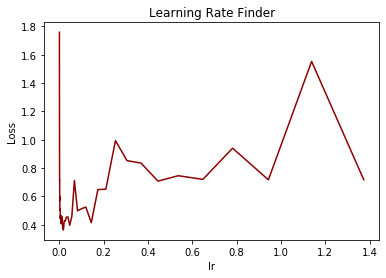

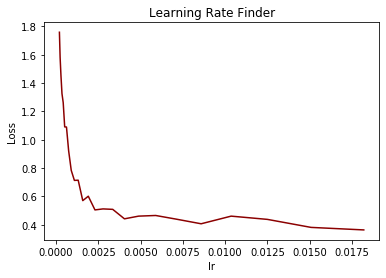

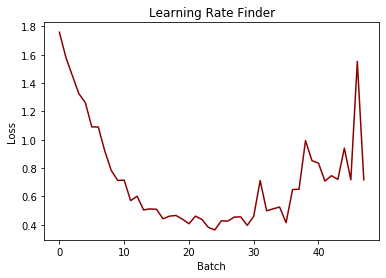

In [0]:
plot_lr(learning_rates, train_loss_epochs, "LossByLearningRate")
plot_lr(learning_rates[:25], train_loss_epochs[:25], "LossByLearningRate")
plot_lr(list(range(len(learning_rates)))[:], train_loss_epochs[:], "LossByLearningRate", ("Batch", "Loss"))

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps

LossByBatch.png
LossByLearningRate.png
LossByLearningRateZoom.png
LossByBatch.pdf
LossByLearningRate.pdf
LossByLearningRateZoom.pdf
LossByBatch.eps
LossByLearningRate.eps
LossByLearningRateZoom.eps


In [0]:
files.download("images.tar.gz")

In [0]:
class EpochStats:
    def __init__(self, classes=[SHOWER, TRACK]):
        self.loss = []
        self.accuracy = []
        self.class_accuracy = { key : [] for key in classes }

    def add_loss(self, loss):
        self.loss.append(loss)
    
    def add_accuracy(self, acc, cls=None):
        if cls is None:
            self.accuracy.append(acc)
        else:
            self.class_accuracy[cls].append(acc)

    def get_losses(self):
        return np.array(self.loss)
    
    def get_accuracies(self, cls=None):
        if cls is None:
            return np.array(self.accuracy)
        else:
            return np.array(self.class_accuracy[cls])

class TrainingInfo:
    def __init__(self):
        self.learning_rates = []

def one_epoch(epoch, model, optim, scheduler, dl, training):
    stats = EpochStats()
    info = TrainingInfo()
    for i, batch in enumerate(dl):
        images, masks = batch
        x = Variable(images)
        y = Variable(masks)
        #print("std, mean = ", torch.std_mean(x))
        pred = model.forward(x)

        loss = loss_fn(pred, y)
        stats.add_loss(loss.item())

        acc = accuracy(pred, y)
        track_acc = type_accuracy(pred, y, TRACK)
        shower_acc = type_accuracy(pred, y, SHOWER)
        stats.add_accuracy(acc)
        stats.add_accuracy(track_acc, TRACK)
        stats.add_accuracy(shower_acc, SHOWER)

        # Just one learning rate for now
        info.learning_rates.append(scheduler.get_lr()[0])

        if not training and i == (len(dl) - 1):
            net_input = x.detach().numpy()
            net_pred = pred.detach().numpy()
            net_mask = y.detach().numpy()
            iu.show_batch(epoch, i, net_input, net_pred, net_mask, void_code, training, n=images.shape[0], randomize=False)
        
        print("Batch {} [{}]: Train Loss: {}   Train Acc: {}   S Acc: {} T Acc: {}".format(
            i + 1, info.learning_rates[-1], loss.item(), acc, shower_acc, track_acc))

        if training:
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
    return stats, info

In [122]:
# Register hooks for feature map visualisation
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.c1.register_forward_hook(get_activation('ResBlock1'))
model.c2.register_forward_hook(get_activation('ResBlock2'))
model.c3.register_forward_hook(get_activation('ResBlock3'))
model.c4.register_forward_hook(get_activation('ResBlock4'))
model.c5.register_forward_hook(get_activation('Bridge'))
model.c6.register_forward_hook(get_activation('TransConvBlock4'))
model.c7.register_forward_hook(get_activation('TransConvBlock3'))
model.c8.register_forward_hook(get_activation('TransConvBlock2'))
model.c9.register_forward_hook(get_activation('TransConvBlock1'))

***Training***
Batch 1 [0.005]: Train Loss: 1.6337532997131348   Train Acc: 0.2350127249956131   S Acc: 0.39573603868484497 T Acc: 0.1365106999874115
Batch 2 [0.006666666666666666]: Train Loss: 0.8629648685455322   Train Acc: 0.7439659237861633   S Acc: 0.6913283467292786 T Acc: 0.7858590483665466
Batch 3 [0.008333333333333333]: Train Loss: 0.7746356129646301   Train Acc: 0.7663711309432983   S Acc: 0.7671328783035278 T Acc: 0.7658055424690247
Batch 4 [0.01]: Train Loss: 0.6732879877090454   Train Acc: 0.8399913907051086   S Acc: 0.8822723031044006 T Acc: 0.8155691623687744
Batch 5 [0.009868427631578948]: Train Loss: 0.7104058861732483   Train Acc: 0.8183326721191406   S Acc: 0.8477222919464111 T Acc: 0.7961447834968567
Batch 6 [0.009736855263157896]: Train Loss: 0.6216546893119812   Train Acc: 0.8277994990348816   S Acc: 0.8895833492279053 T Acc: 0.7630007266998291
Batch 7 [0.009605282894736842]: Train Loss: 0.6469969749450684   Train Acc: 0.8023903369903564   S Acc: 0.931521177291870

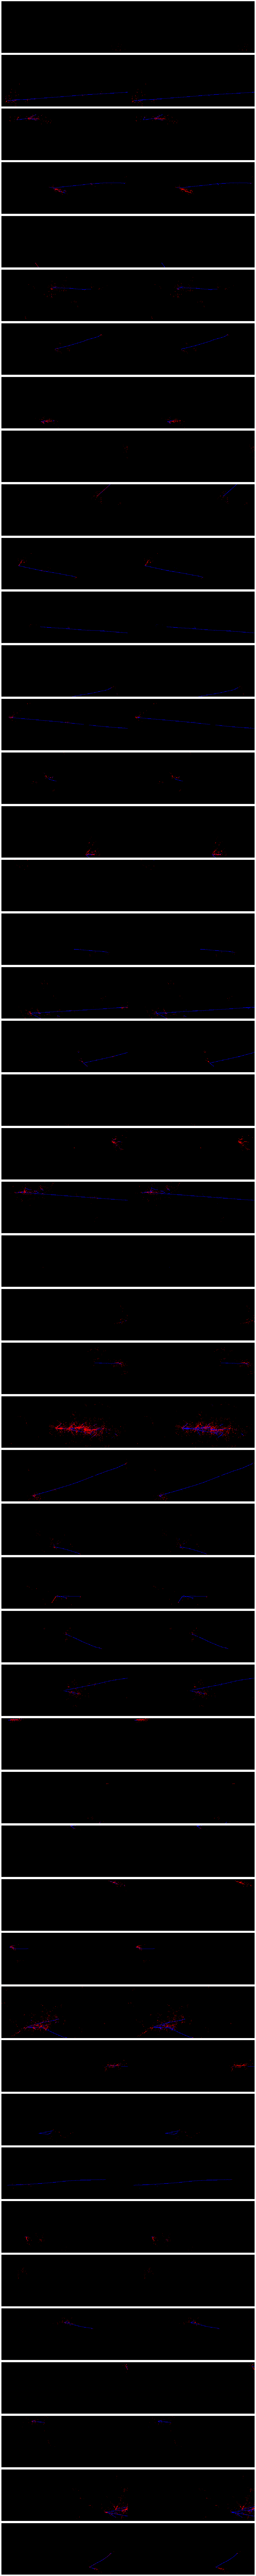

In [123]:
# Run
num_epochs=1
stats = [None] * num_epochs
info = [None] * num_epochs
val_stats = [None] * num_epochs
for epoch in list(range(0, num_epochs)):
    # Training
    print("***Training***")
    model = model.train()
    optim.zero_grad()
    stats[epoch], info[epoch] = one_epoch(epoch, model, optim, scheduler, bunch.train_dl, True)
    # Validation
    print("***Validating***")
    model = model.eval()

    for group in model.children():
        if type(group) == nn.Sequential:
            for child in group:
                if type(child)==nn.BatchNorm2d:
                    child.track_running_stats = False

    with torch.no_grad():
        val_stats[epoch], _ = one_epoch(epoch, model, optim, scheduler, bunch.valid_dl, False)
    print("Epoch {} : loss {} acc {}   val_loss {} val_acc {}:".format(
        epoch + 1, stats[epoch].get_losses().mean(), stats[epoch].get_accuracies().mean(),
        val_stats[epoch].get_losses().mean(), val_stats[epoch].get_accuracies().mean()))

[ 0  3  4  6  7  8  9 11 13]
[ 3  5  9 10 17 18 19 22 29]
[ 6  9 18 26 34 35 43 58 59]
[ 18  29  31  56  68  87  91 103 111]
[  1  30  32  86 143 153 168 190 255]
[ 4  7 18 32 55 64 77 78 99]
[ 8 20 27 31 36 40 44 46 47]
[ 9 10 11 19 22 25 28 30 31]
[ 2  3  6  7  8 10 11 13 15]


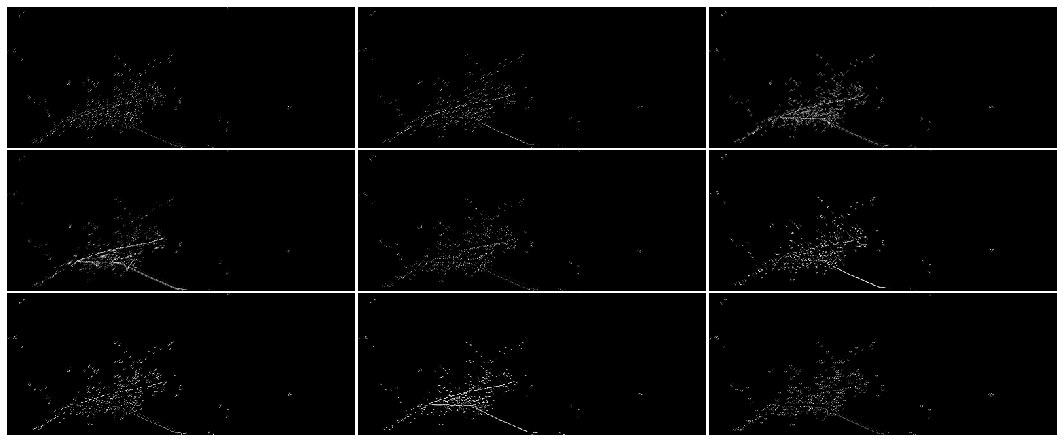

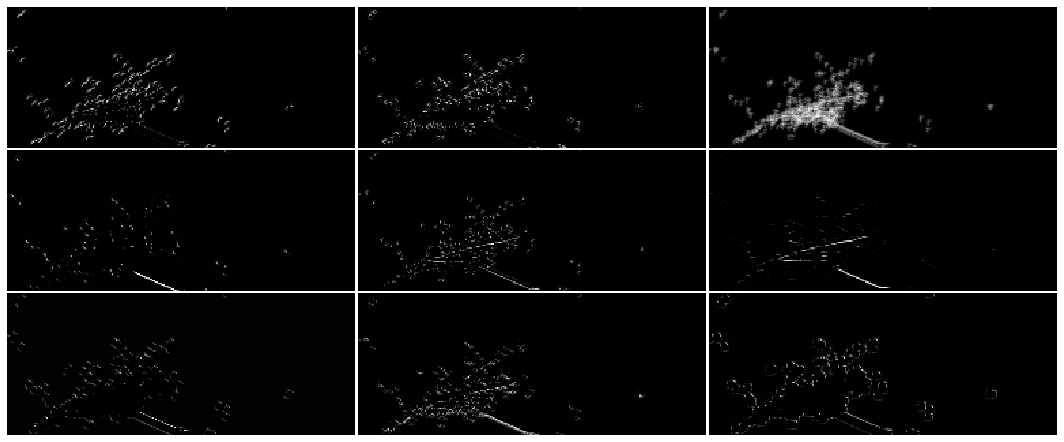

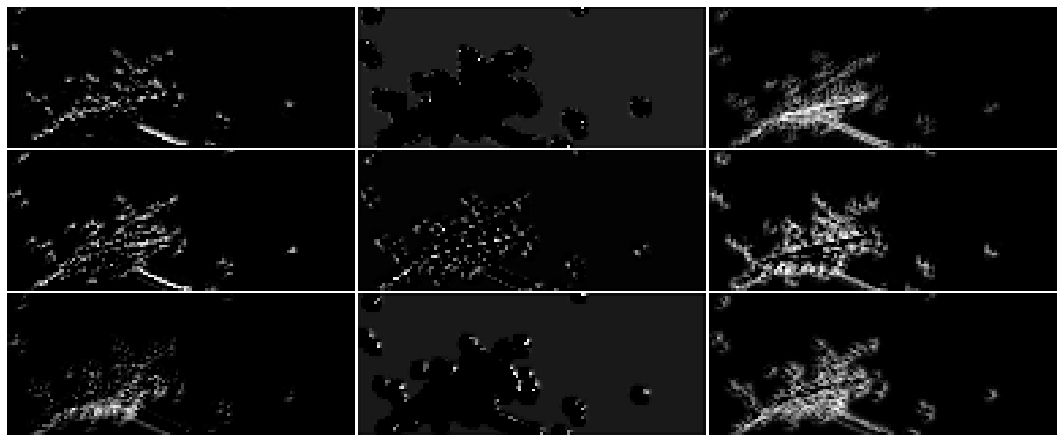

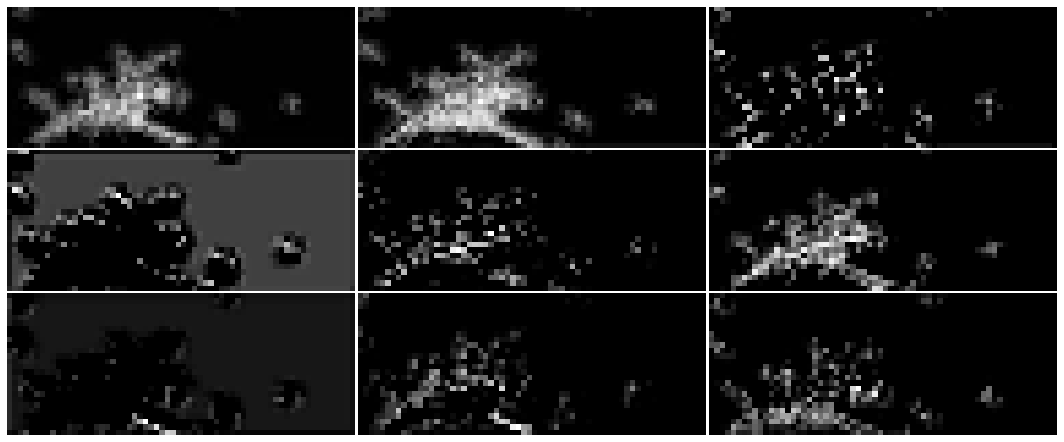

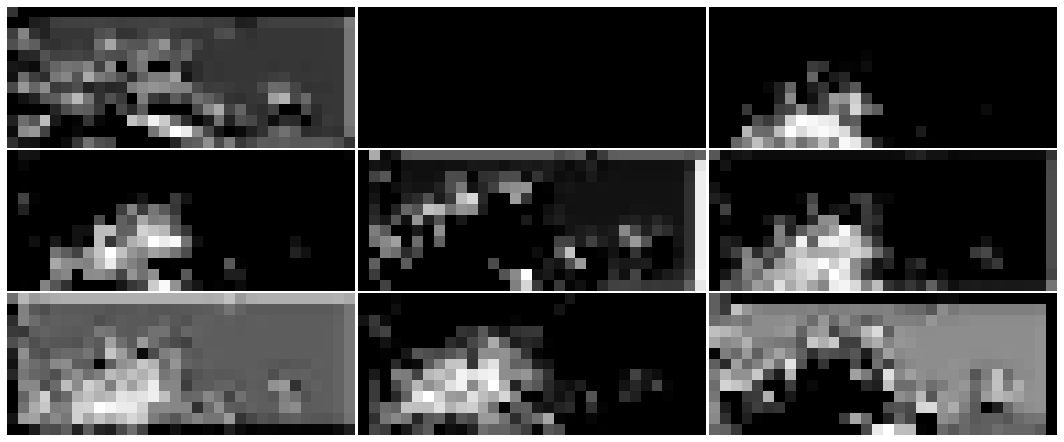

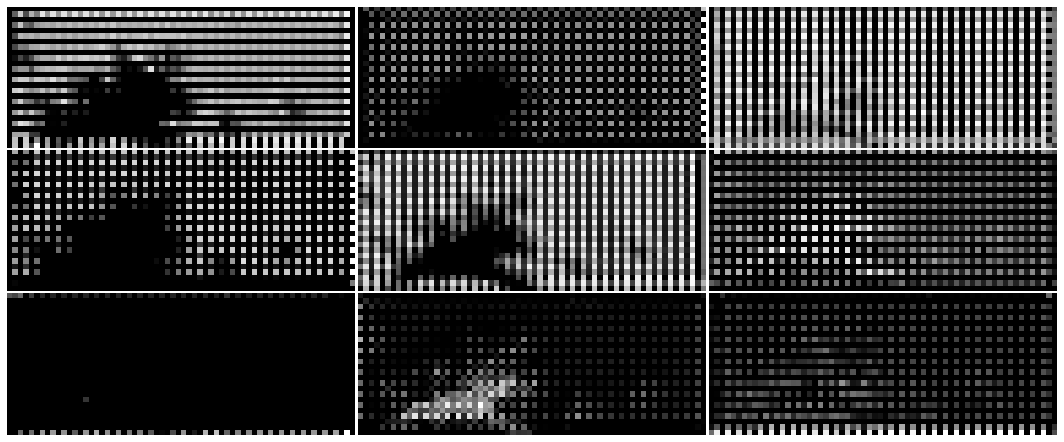

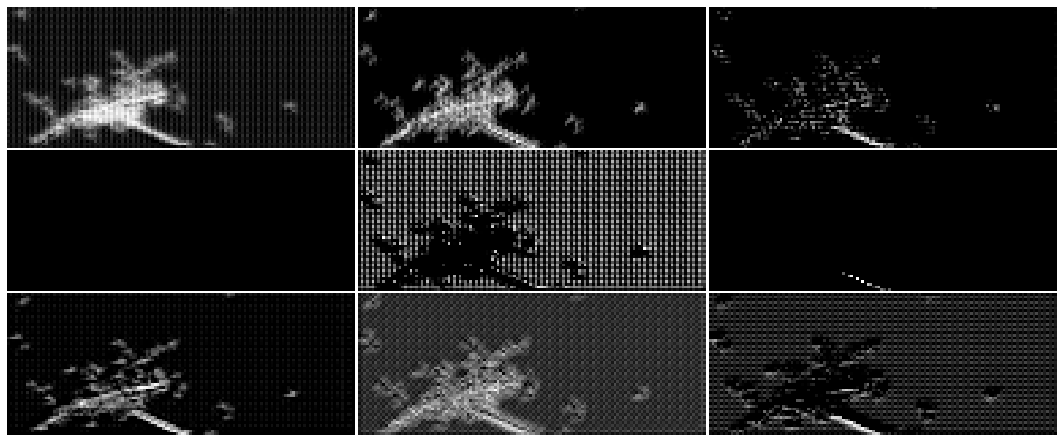

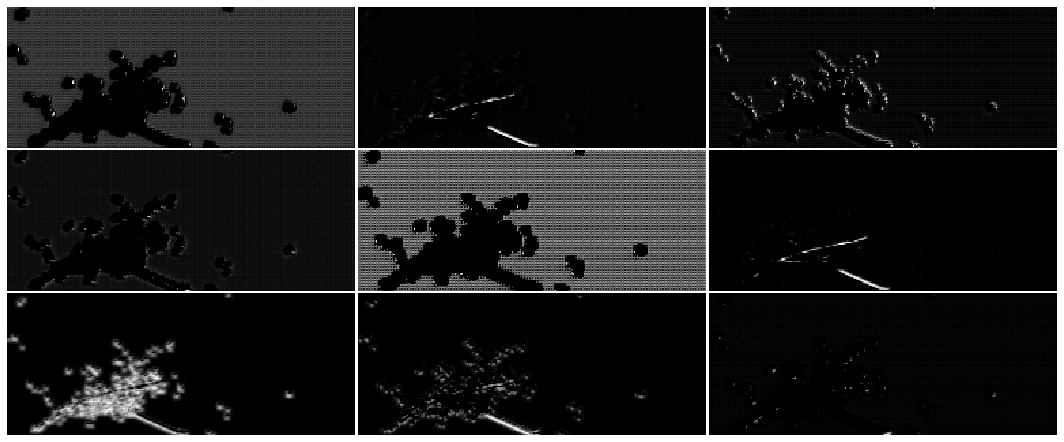

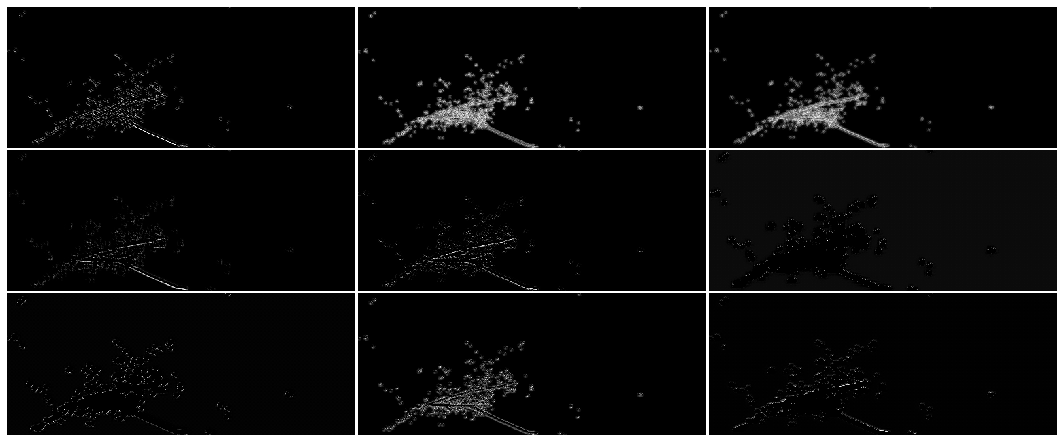

In [157]:
# Visualize feature maps
names = ['ResBlock1','ResBlock2','ResBlock3','ResBlock4','Bridge',
         'TransConvBlock4','TransConvBlock3','TransConvBlock2','TransConvBlock1']
for name in names:
    act = activation[name].squeeze()
    choices = np.sort(np.random.choice(list(range(act.size(1))), size = 9, replace = False))
    act = act[:,choices]
    fig, ax = plt.subplots(act.size(1) // 3, act.size(1) // 3, figsize=(15,6))
    print(choices)
    for img_idx in [3, 19, 26, 27, 37]:
        tot_act = torch.sum(act[img_idx], dim=0)
        for filter_idx in range(act.size(1)):
            ax[filter_idx // 3, filter_idx % 3].axis('off')
            ax[filter_idx // 3, filter_idx % 3].imshow(act[img_idx, filter_idx], cmap=plt.get_cmap("Greys_r"))
        plt.tight_layout(pad=0.2)
        iu.save_figure(plt, f"{name}_{img_idx}")

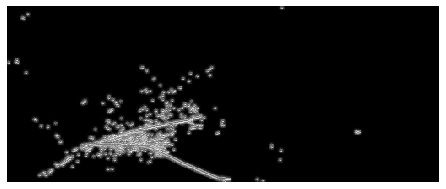

In [159]:
# Heat maps
names = ['ResBlock1','ResBlock2','ResBlock3','ResBlock4','Bridge',
         'TransConvBlock4','TransConvBlock3','TransConvBlock2','TransConvBlock1']
for name in names:
    act = activation[name].squeeze()
    for img_idx in [3, 19, 26, 27, 37]:
        tot_act = torch.sum(act[img_idx], dim=0)
        plt.axis('off')
        plt.imshow(tot_act, cmap=plt.get_cmap("Greys_r"))
        plt.tight_layout(pad=0)
        iu.save_figure(plt, f"{name}_{img_idx}_heatmap")

torch.Size([128, 128, 3, 3])
[  5  13  17  33  38  39  48  70  75  78  82  92  99 103 108 110]


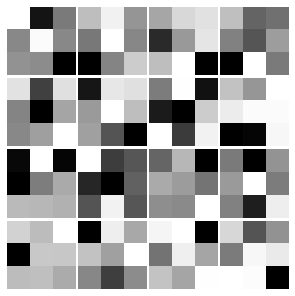

In [156]:
filters = model.c4.conv2.weight.data
print(filters.size())
N = filters.size(0)
choices = np.sort(np.random.choice(list(range(N)), size = 16, replace = False))
# First conv has only 1 input channel, but subsequent conv can have many
filters = filters[choices, 0]
N = filters.size(0)
grid = 4
fig, ax = plt.subplots(N // grid, N // grid, figsize=(grid,grid))
print(choices)
for filter_idx in range(N):
    ax[filter_idx // grid, filter_idx % grid].axis('off')
    ax[filter_idx // grid, filter_idx % grid].imshow(filters[filter_idx], cmap=plt.get_cmap("Greys_r"))
plt.tight_layout(pad=0.3)
iu.save_figure(plt, f"ResBlock1_Conv2_{filter_idx}")

In [0]:
imgs = None
for batch in bunch.valid_dl:
    imgs, _ = batch
    break
imgs.shape[0]

48

In [0]:
def plot_lr_loss_acc(lrs, losses, accuracies, name):
    fig, axs = plt.subplots(3, 1, figsize=(6,9), sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy = np.array([lrs, losses, accuracies])
    axes = ["lr", "loss", "acc"]
    labels = ["Overall", "Track", "Shower"]
    colors = ['black', 'blue', 'red']
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(axes[i])
        if len(yy[i].shape) == 1:
            ax.plot(xx, yy[i], c='black')
        else:
            for j, y in enumerate(yy[i]):
                ax.plot(xx, y, c=colors[j], label=labels[j])
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    plt.legend()
    iu.save_figure(fig, name)

def plot_loss_acc(losses, accuracies, name):
    fig, axs = plt.subplots(2, 1, figsize=(6,9), sharex=True)
    xx = list(range(1, 1 + len(losses)))
    yy = np.array([losses, accuracies])
    axes = ["loss", "acc"]
    labels = ["Overall", "Track", "Shower"]
    colors = ['black', 'blue', 'red']
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(axes[i])
        if len(yy[i].shape) == 1:
            ax.plot(xx, yy[i], c='black')
        else:
            for j, y in enumerate(yy[i]):
                ax.plot(xx, y, c=colors[j], label=labels[j])
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    plt.legend()
    iu.save_figure(fig, name)

In [0]:
# Training stats
batch_lrs = np.concatenate([i.learning_rates for i in info])
batch_losses = np.concatenate([s.get_losses() for s in stats])
batch_overall_accuracies = np.concatenate([s.get_accuracies() for s in stats])
batch_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in stats])
batch_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in stats])
batch_accuracies = np.array([batch_overall_accuracies, batch_track_accuracies, batch_shower_accuracies])

np.save("learning_rates", batch_lrs)
np.save("losses", batch_losses)
np.save("accuracies", batch_overall_accuracies)
np.save("track_accuracies", batch_track_accuracies)
np.save("shower_accuracies", batch_shower_accuracies)

In [0]:
# Validation stats
batch_val_losses = np.concatenate([s.get_losses() for s in val_stats])
batch_val_overall_accuracies = np.concatenate([s.get_accuracies() for s in val_stats])
batch_val_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in val_stats])
batch_val_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in val_stats])
batch_val_accuracies = np.array([batch_val_overall_accuracies, batch_val_track_accuracies, batch_val_shower_accuracies])

np.save("val_losses", batch_val_losses)
np.save("val_accuracies", batch_val_overall_accuracies)
np.save("val_track_accuracies", batch_val_track_accuracies)
np.save("val_shower_accuracies", batch_val_shower_accuracies)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


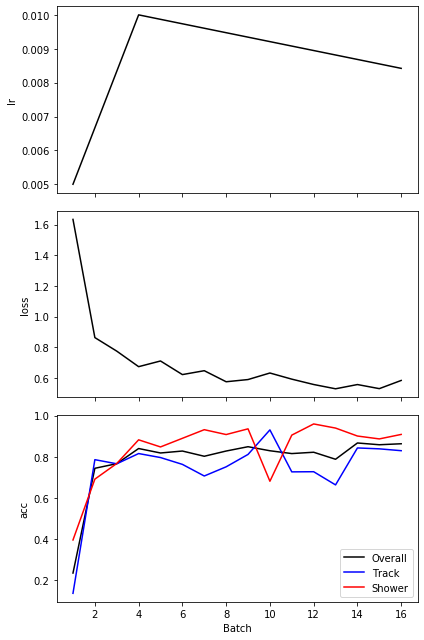

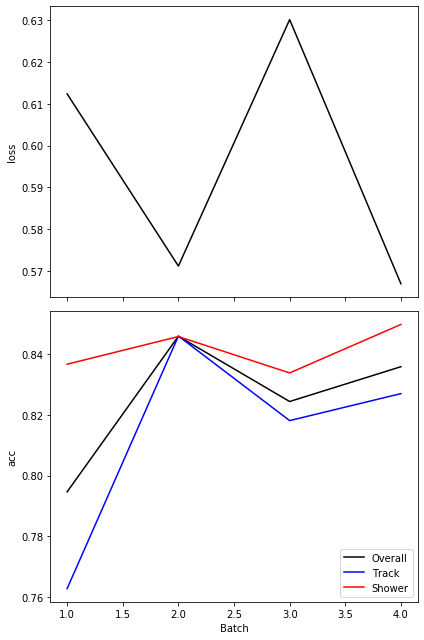

In [128]:
plot_lr_loss_acc(batch_lrs, batch_losses, batch_accuracies, "LRLossAccByBatch")
plot_loss_acc(batch_val_losses, batch_val_accuracies, "LossAccByBatch")

In [0]:
# Upload pickle files
from google.colab import files
files.upload()

Saving flat_acc.npy to flat_acc.npy
Saving flat_losses.npy to flat_losses.npy
Saving flat_lr.npy to flat_lr.npy


{'flat_acc.npy': b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (85,), }                                                           \n\x00\x00\x00`;\x8f\xe0?\x00\x00\x00`\x84\x1b\xe4?\x00\x00\x00\x80_r\xe7?\x00\x00\x00`=\xa3\xe6?\x00\x00\x00\x80\xbcU\xe7?\x00\x00\x00\x00\x1c\x88\xe8?\x00\x00\x00 Q9\xe8?\x00\x00\x00`\x00\xa1\xe8?\x00\x00\x00\xc0\xa5a\xea?\x00\x00\x00@\x10\xd5\xe9?\x00\x00\x00 c#\xe9?\x00\x00\x00\xe0\xae\x8b\xea?\x00\x00\x00\x80$\x80\xe9?\x00\x00\x00 \x03\xa6\xe9?\x00\x00\x00\xa0\x7f\xf7\xe9?\x00\x00\x00 \xb0o\xe9?\x00\x00\x00\xa0\xbfv\xea?\x00\x00\x00\xe08\x05\xea?\x00\x00\x00`\x1e\x90\xea?\x00\x00\x00\xa0?.\xeb?\x00\x00\x00\x80m\xbc\xea?\x00\x00\x00 \xec\xec\xe9?\x00\x00\x00\xc0\xdd\x16\xea?\x00\x00\x00 \xa2F\xea?\x00\x00\x00\x80\xa5\x16\xeb?\x00\x00\x00 \x91\xb9\xeb?\x00\x00\x00`\xd5\x99\xeb?\x00\x00\x00\x00q\xc0\xeb?\x00\x00\x00\xe0\xb9n\xeb?\x00\x00\x00`\x01h\xe9?\x00\x00\x00 \x84\r\xec?\x00\x00\x00 Ue\xec?\x00\x00\x00\x00\x92\x1e\xea?\x00\

In [0]:
# Upload some comparison data
import numpy as np
learning_rates = np.load("flat_lr.npy")
train_loss_batches = np.load("flat_losses.npy")
train_acc_batches = np.load("flat_acc.npy")

In [0]:
# Upload pickle files
!rm -f cycle_*.npy 
from google.colab import files
files.upload()

Saving cycle_acc.npy to cycle_acc.npy
Saving cycle_losses.npy to cycle_losses.npy
Saving cycle_lr.npy to cycle_lr.npy


{'cycle_acc.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': False, \'shape\': (85,), }                                                           \n\x00\x00\x00\x80\x8f\x0b\xdf?\x00\x00\x00\xc0\xc8\x0c\xe6?\x00\x00\x00\xa0Z\x8b\xe7?\x00\x00\x00`R\x82\xe5?\x00\x00\x00`\xdc+\xe7?\x00\x00\x00\xc0\x99b\xe8?\x00\x00\x00\x00&\xe3\xe8?\x00\x00\x00@\xf6N\xe9?\x00\x00\x00\xc0\xefN\xea?\x00\x00\x00\xc0\xbd.\xeb?\x00\x00\x00 \x98C\xea?\x00\x00\x00@(\x01\xea?\x00\x00\x00\x00\x84\x96\xeb?\x00\x00\x00\xe02W\xeb?\x00\x00\x00 \xce\x13\xea?\x00\x00\x00\x00\x16\xbc\xeb?\x00\x00\x00\x00\x8f^\xe6?\x00\x00\x00 \xe1N\xeb?\x00\x00\x00@U\xe0\xe9?\x00\x00\x00 ~\xc4\xe9?\x00\x00\x00\x80\x97;\xea?\x00\x00\x00\x80\x18.\xea?\x00\x00\x00\x80W\\\xe8?\x00\x00\x00\x00&$\xeb?\x00\x00\x00`\xf29\xea?\x00\x00\x00\xa0O"\xea?\x00\x00\x00`\x9f\xc0\xea?\x00\x00\x00 \xceW\xeb?\x00\x00\x00\xa0D\xff\xe9?\x00\x00\x00 <\xfe\xe9?\x00\x00\x00@o\xa2\xeb?\x00\x00\x00\x80\xcb\x86\xeb?\x00\x00\x00@M\x10\xeb?\x00\x00

In [0]:
cycle_lr = np.load("cycle_lr.npy")
cycle_losses = np.load("cycle_losses.npy")
cycle_acc = np.load("cycle_acc.npy")

In [0]:
def plot_multi_lr_loss_acc(lrs, losses, accuracies, lrs2, losses2, acc2, name):
    fig, axs = plt.subplots(2, 1, sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy_flat = [lrs, losses, accuracies]
    yy_cycle = [lrs2, losses2, acc2]
    xlabels = ["lr", "loss", "acc"]
    labels = ["Constant", "One-Cycle"]
    colors = [['black', 'black', 'black'],['red', 'red', 'red']]
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(xlabels[i])
        ax.plot(xx, yy_flat[i], c=colors[0][i], label=labels[0])
        ax.plot(xx, yy_cycle[i], c=colors[1][i], label=labels[1])
    axs[0].legend()
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


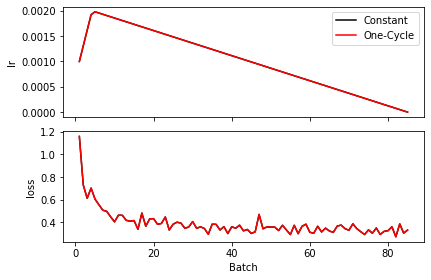

In [0]:
plot_multi_lr_loss_acc(learning_rates, train_loss_batches, train_acc_batches, cycle_lr, cycle_losses, cycle_acc, "MultiLRLossAcc")

In [0]:
#del x, y
#del images, masks
#del model
torch.cuda.empty_cache()

In [0]:
def plot_stat_epoch(train_stats, val_stats, stat="Loss"):
    epochs = np.array(list(range(1, len(train_stats) + 1)), dtype=np.int16)
    fig, ax = plt.subplots()
    ax.set_title(f'Model {stat}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{stat}')
    ax.plot(epochs, train_stats, label='Training', c='red')
    ax.plot(epochs, val_stats, label='Validation', c='blue')
    if stat == "Loss": ax.legend(loc='upper right')
    else: ax.legend(loc='upper left')
    iu.save_figure(plt, f"Average{stat}VsTrainingEpoch")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


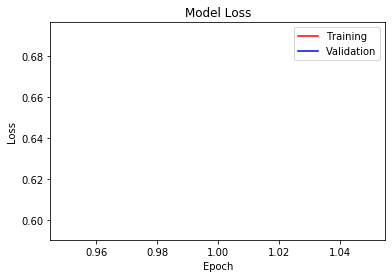

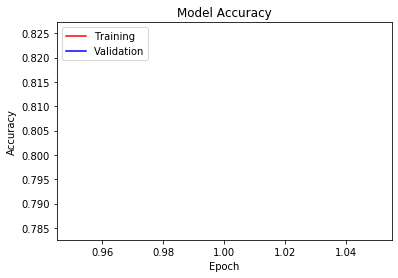

In [110]:
train_loss_epochs = [s.get_losses().mean() for s in stats]
val_loss_epochs = [s.get_losses().mean() for s in val_stats]
plot_stat_epoch(train_loss_epochs, val_loss_epochs)

train_acc_epochs = [s.get_accuracies().mean() for s in stats]
val_acc_epochs = [s.get_accuracies().mean() for s in val_stats]
plot_stat_epoch(train_acc_epochs, val_acc_epochs, stat="Accuracy")

In [160]:
!tar cvzf images.tar.gz *.png *.pdf *.eps *.npy
files.download("images.tar.gz")

AverageAccuracyVsTrainingEpoch.png
AverageLossVsTrainingEpoch.png
Bridge_19_heatmap.png
Bridge_19.png
Bridge_26_heatmap.png
Bridge_26.png
Bridge_27_heatmap.png
Bridge_27.png
Bridge_37_heatmap.png
Bridge_37.png
Bridge_3_heatmap.png
Bridge_3.png
LossAccByBatch.png
LRLossAccByBatch.png
ResBlock1_19_heatmap.png
ResBlock1_19.png
ResBlock1_26_heatmap.png
ResBlock1_26.png
ResBlock1_27_heatmap.png
ResBlock1_27.png
ResBlock1_37_heatmap.png
ResBlock1_37.png
ResBlock1_3_heatmap.png
ResBlock1_3.png
ResBlock1_Conv1_15.png
ResBlock1_Conv1_8.png
ResBlock1_Conv2_15.png
ResBlock2_19_heatmap.png
ResBlock2_19.png
ResBlock2_26_heatmap.png
ResBlock2_26.png
ResBlock2_27_heatmap.png
ResBlock2_27.png
ResBlock2_37_heatmap.png
ResBlock2_37.png
ResBlock2_3_heatmap.png
ResBlock2_3.png
ResBlock3_19_heatmap.png
ResBlock3_19.png
ResBlock3_26_heatmap.png
ResBlock3_26.png
ResBlock3_27_heatmap.png
ResBlock3_27.png
ResBlock3_37_heatmap.png
ResBlock3_37.png
ResBlock3_3_heatmap.png
ResBlock3_3.png
ResBlock4_19_heatmap.png

In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

Total size: 0


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.
